## Universidade Estadual de Campinas 
## Instituto de Computação
# Imparcialidade
## MO810/MC959 - Tópicos em Inteligência Artificial
## Ética em Aprendizado de Máquina
### Prof. Marcos M. Raimundo
---
### Alunos:
#### Mateus Trentini RA 217290
#### Mauricio Pereira Lopes RA 225242
#### Rita Braga RA 251627
---

In [35]:
# load required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.datasets import StandardDataset
from aif360 import sklearn

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [23]:
# load datasets

df_train = pd.read_excel("../data/processed/train_data.xlsx")
df_val = pd.read_excel("../data/processed/validation_data.xlsx")
df_test = pd.read_excel("../data/processed/test_data.xlsx")
df_train.head()

,Unnamed: 0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,27623,27623,50000,2,1,2,23,-1,-1,-1,...,4800,9810,660,2548,2321,4800,9810,660,2980,0
1,28377,28377,50000,2,2,1,36,2,2,2,...,47956,43578,35126,0,4700,0,2004,3500,0,0
2,10918,10918,200000,2,3,1,54,6,5,4,...,102549,101400,0,0,0,0,0,0,0,0
3,27235,27235,240000,1,1,1,35,-1,-1,-1,...,17102,13367,22659,2017,21817,1120,13434,22772,22820,0
4,15172,15172,60000,2,1,2,23,0,0,0,...,8549,7635,12258,3126,1392,5033,3601,5200,3647,0


---
# Enuncie e apresente uma ou mais métricas de imparcialidade mais ajustadas à aplicação escolhida, justifique.

---
## Measuring Fairness Using Equal Opportunity

In [24]:
# load trained model
rf_model = pickle.load(open('../models/best_rf.pkl', 'rb'))

In [25]:
# predict on validation dataset
X_val = df_val.drop(columns=['Unnamed: 0', 'ID', 'default payment next month'])
# Random Forest model's prediction
y_hat_rf = rf_model.predict(X_val)

In [26]:
def equal_opp(df_val, y_pred, y_val, priv_class, unpriv_class, sensitive_attribute_name):
    
    # create new datafrane with sensitive attributes, predictions for each model and ground truth
    y_hat_vs_y_val = pd.DataFrame({sensitive_attribute_name: df_val[sensitive_attribute_name],
                                   'y_hat_rf': y_pred, 
                                   'y_val': y_val})
    
    # Separate data by sex
    privileged = y_hat_vs_y_val[y_hat_vs_y_val[sensitive_attribute_name] == priv_class]
    unprivileged = y_hat_vs_y_val[y_hat_vs_y_val[sensitive_attribute_name] == unpriv_class]
    
    # Calculate confusion matrices for each group
    privileged_matrix = confusion_matrix(privileged.y_hat_rf, privileged.y_val)
    unprivileged_matrix = confusion_matrix(unprivileged.y_hat_rf, unprivileged.y_val)
    
    # Calculate true positive rates for each group
    privileged_tpr = privileged_matrix[1,1] / (privileged_matrix[1,0] + privileged_matrix[1,1])
    unprivileged_tpr = unprivileged_matrix[1,1] / (unprivileged_matrix[1,0] + unprivileged_matrix[1,1])
    equal_opp_metric = privileged_tpr - unprivileged_tpr

    return privileged_tpr, unprivileged_tpr, equal_opp_metric

In [27]:
male_tpr, female_tpr, equal_opp_metric = equal_opp(df_val,
                                                   y_hat_rf,
                                                   df_val['default payment next month'],
                                                   1,
                                                   2,
                                                   'SEX')

In [28]:
# Compare true positive rates to assess fairness
if equal_opp_metric:
    print("Random Forest model: The algorithm has Equal Opportunity for both groups (male vs female).")
else:
    print("Random Forest model: The algorithm does not have Equal Opportunity for both groups (male vs female).")

# Output true positive rates
print("\nTrue Positive Rates:")
print("Male: {:.3f}".format(male_tpr))
print("Female: {:.3f}".format(female_tpr))
print('Equal Opportunity Metric: {:.3f}'.format(equal_opp_metric))

Random Forest model: The algorithm has Equal Opportunity for both groups (male vs female).

True Positive Rates:
Male: 0.621
Female: 0.667
Equal Opportunity Metric: -0.046


---
## Disparate impact

In [29]:
# calculating DI manually

def calc_prop(data, group_col, group, output_col, output_val):
    new = data[data[group_col] == group]
    return len(new[new[output_col] == output_val])/len(new)

In [30]:
parity_rate_male = calc_prop(df_train, "SEX", 1, "default payment next month", 0)
parity_rate_female = calc_prop(df_train, "SEX", 2, "default payment next month", 0)
print("parity_rate_male:", parity_rate_male)
print("parity_rate_female:", parity_rate_female)
print("parity rate ration female/male:", parity_rate_female/parity_rate_male)

parity_rate_male: 0.7549540840985983
parity_rate_female: 0.7919515837459719
parity rate ration female/male: 1.049006291146233


In [31]:
# calculating DI using AIF360

privileged_groups = [{'SEX': 1}]
unprivileged_groups = [{'SEX': 2}]

binary_label_dataset_original = BinaryLabelDataset(df=df_train, 
                                        label_names=['default payment next month'], 
                                        protected_attribute_names=['SEX'],
                                        favorable_label=0, # non-default
                                        unfavorable_label=1, # default label
                                        )

di = BinaryLabelDatasetMetric(binary_label_dataset_original,
                              unprivileged_groups = unprivileged_groups,
                              privileged_groups = privileged_groups
                             ).disparate_impact()

print("Disparate Impact:", di)

Disparate Impact: 1.049006291146233


## Ajuste dos dados

Como vimos, não há imparcialidade significativa nos dados como estão, assim, por motivos educacionais, mudamos a distribuição de resultados positivos para mulheres de forma que obtenham menos resultados positivos.

In [32]:
# load datasets

df_train = pd.read_excel("../data/processed/train_unfair.xlsx")
df_val = pd.read_excel("../data/processed/validation_unfair.xlsx")
df_test = pd.read_excel("../data/processed/test_unfair.xlsx")
df_train.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,15926,30000,2,2,2,31,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
1,10063,200000,1,2,1,31,1,2,2,0,...,28170,28763,28453,3019,6,991,1032,1310,2000,0
2,19377,500000,2,4,2,38,-2,-2,-2,-2,...,40626,9255,8659,2265,24905,40827,30844,8695,3532,1
3,6385,20000,2,2,2,22,0,0,0,0,...,20055,19606,19925,1298,1909,1666,5000,703,775,0
4,15977,50000,2,2,1,48,1,2,0,0,...,19378,18874,19361,0,2000,1500,1000,2000,1000,1


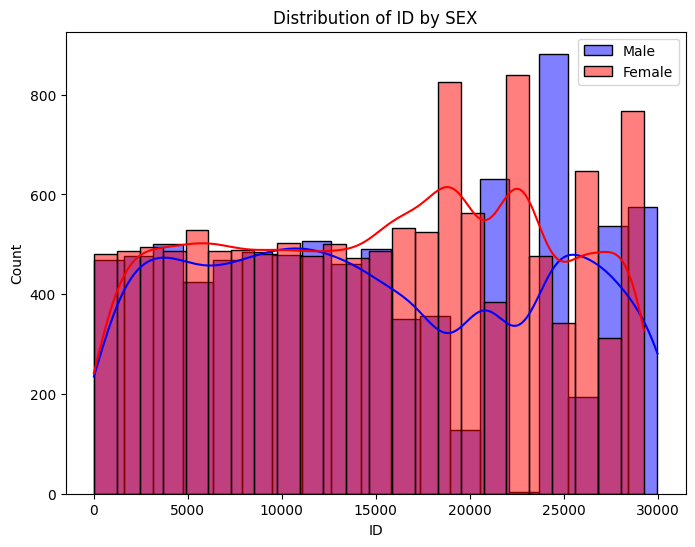

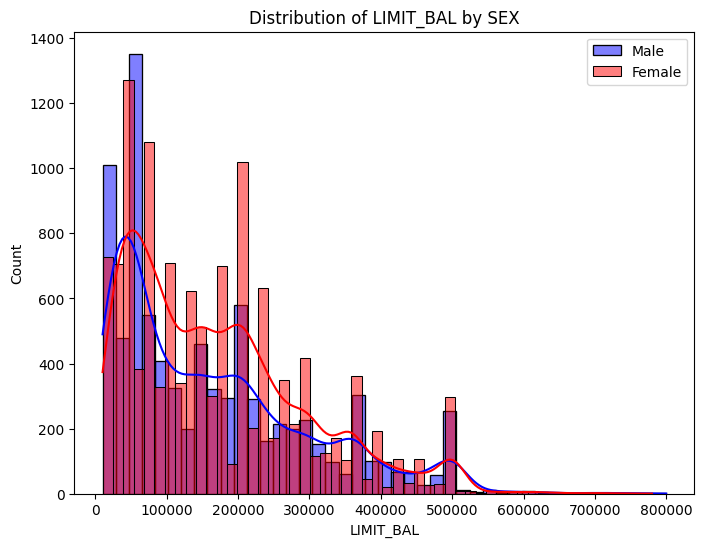

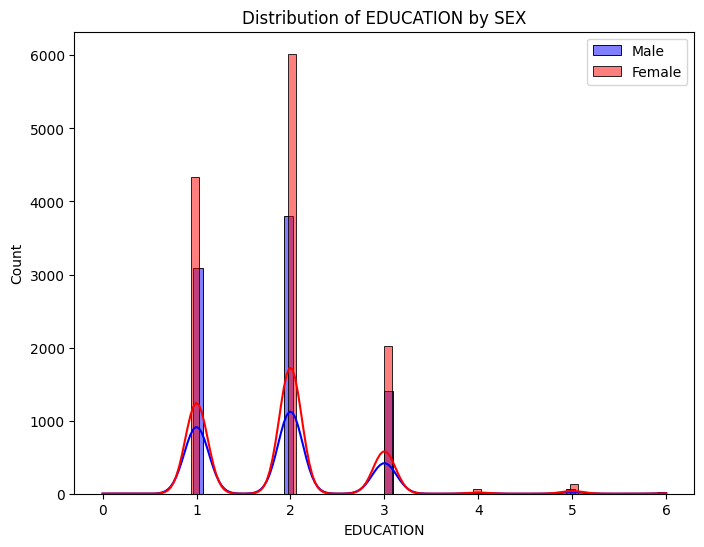

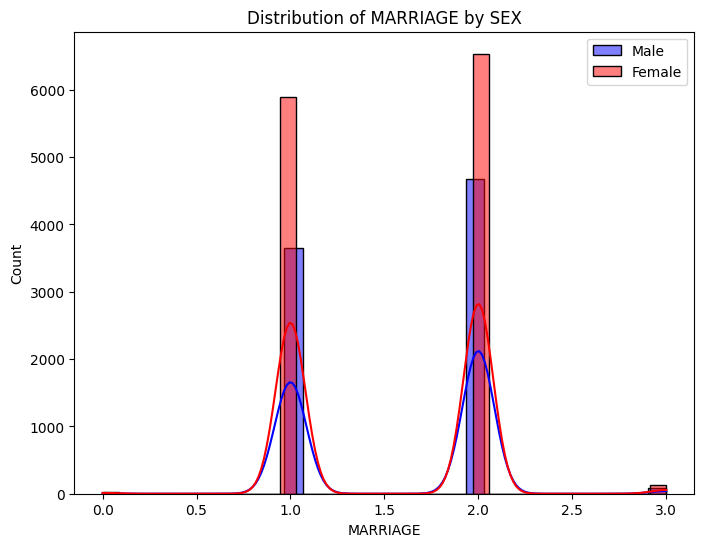

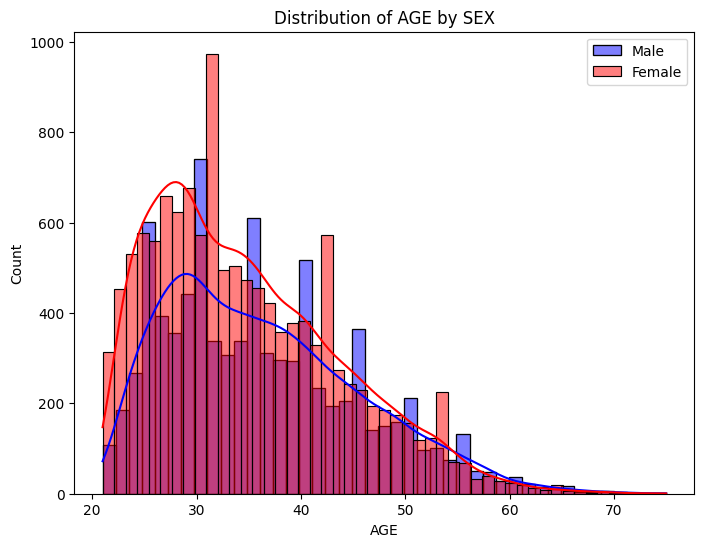

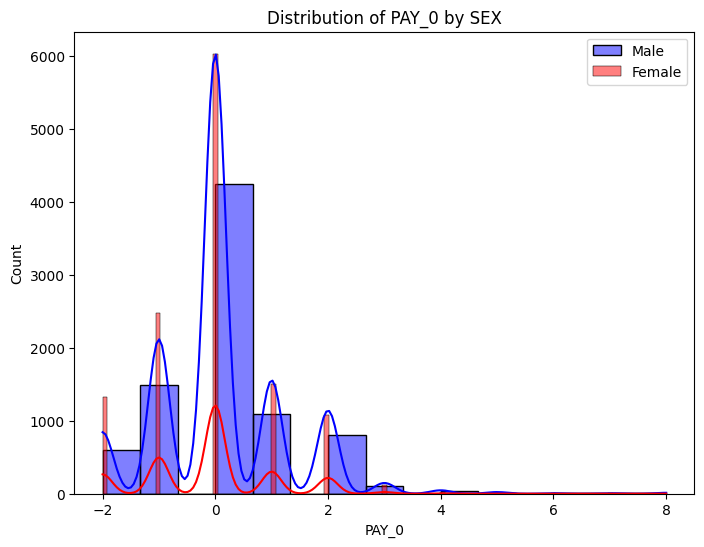

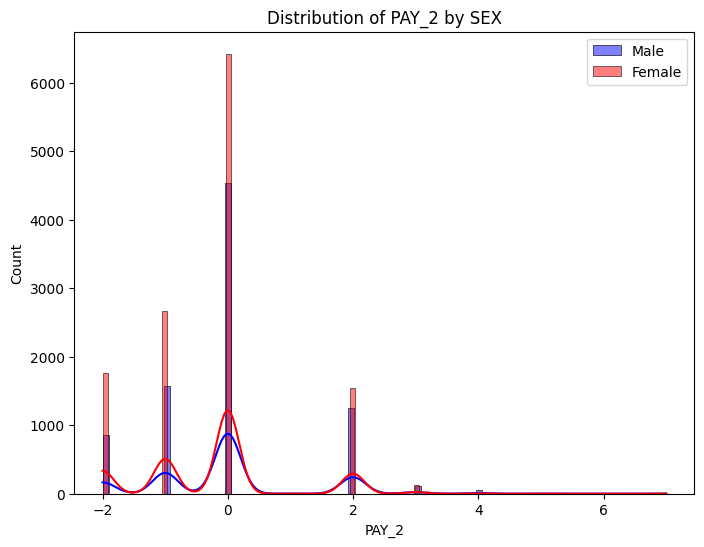

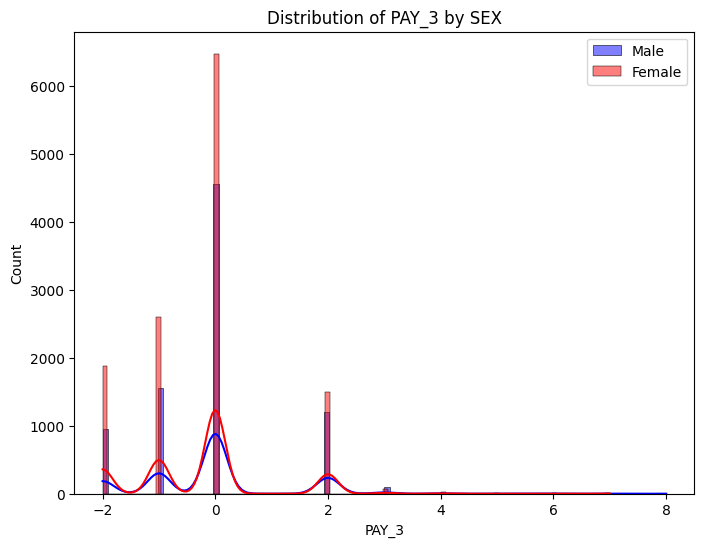

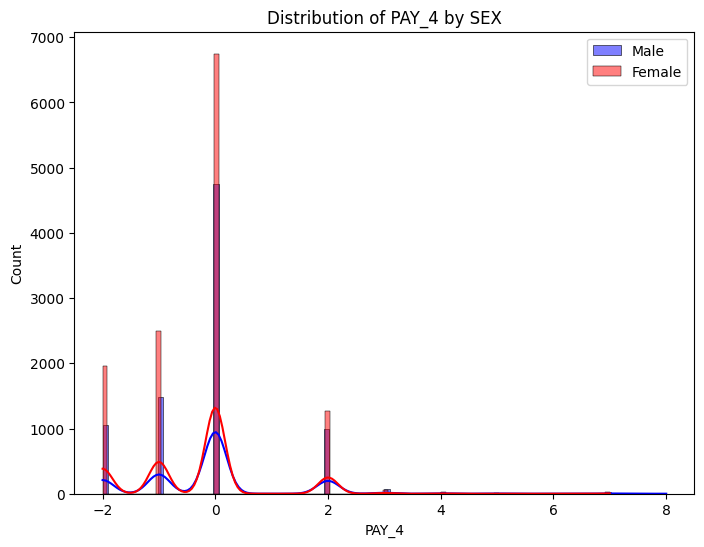

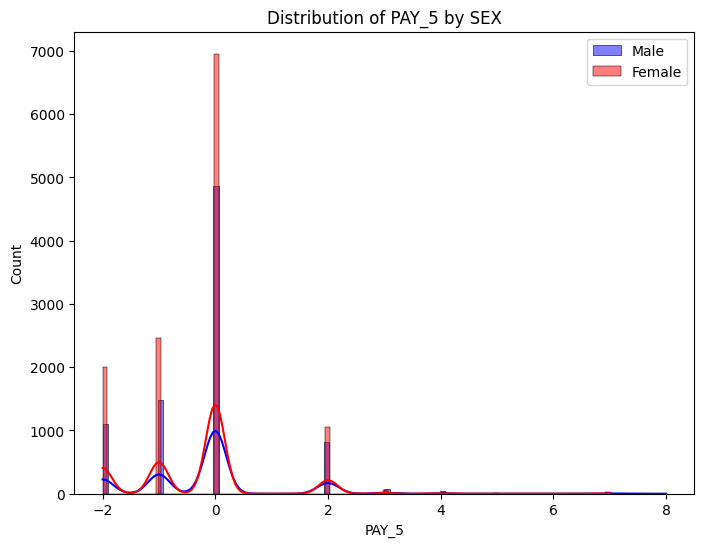

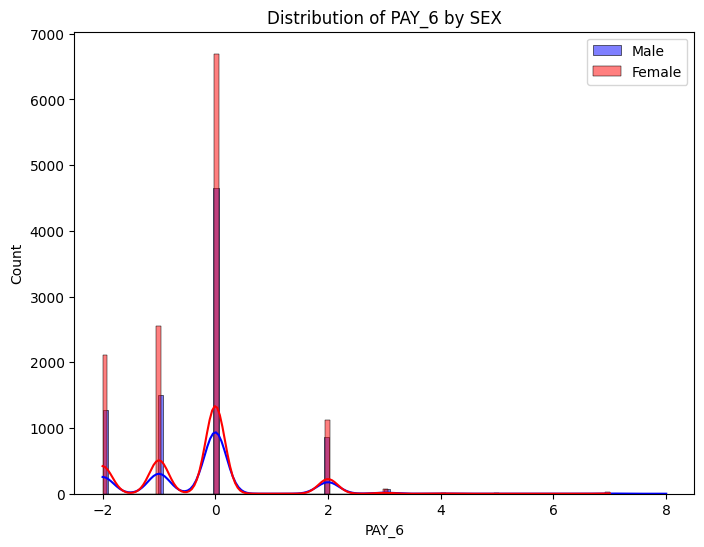

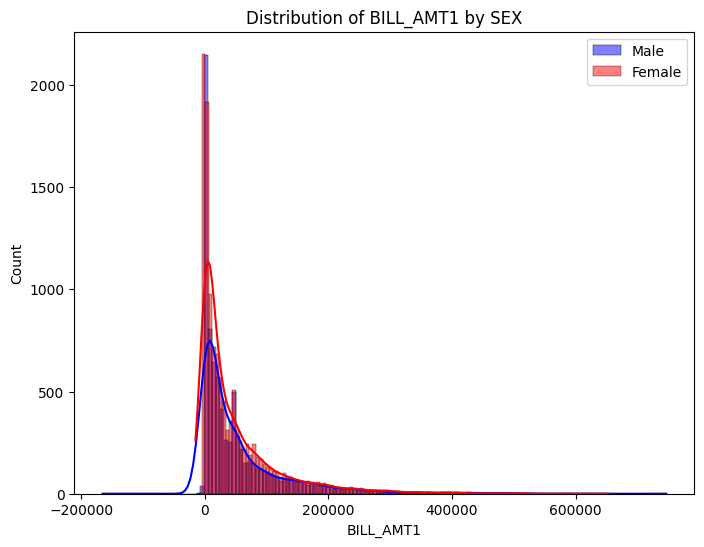

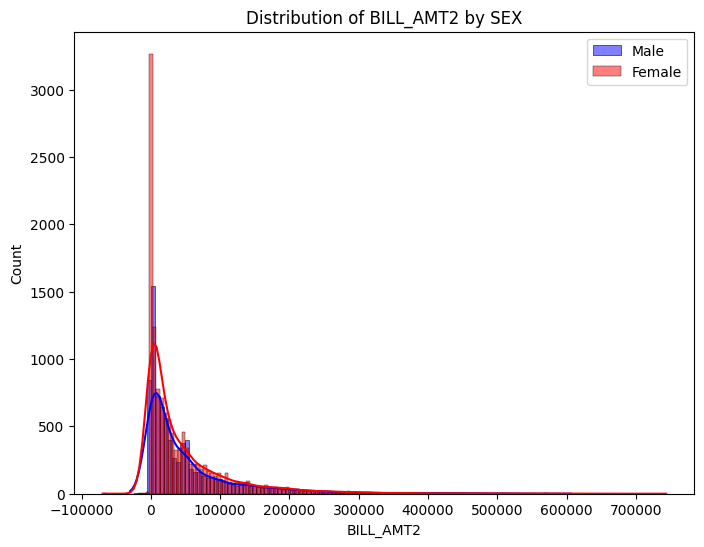

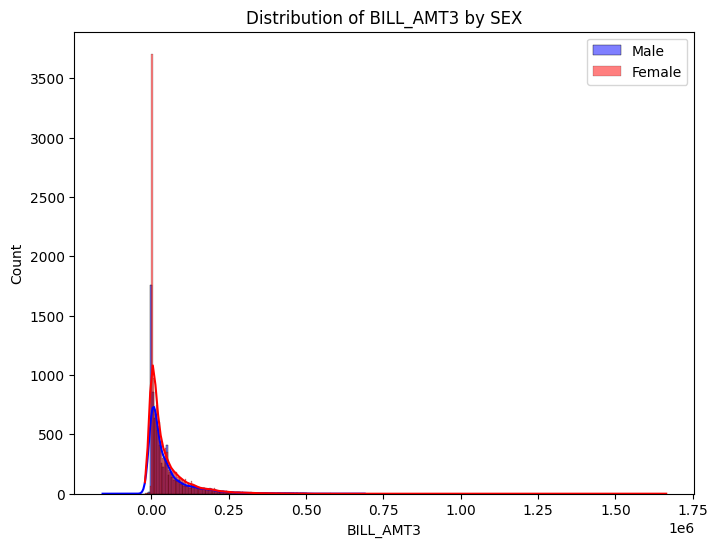

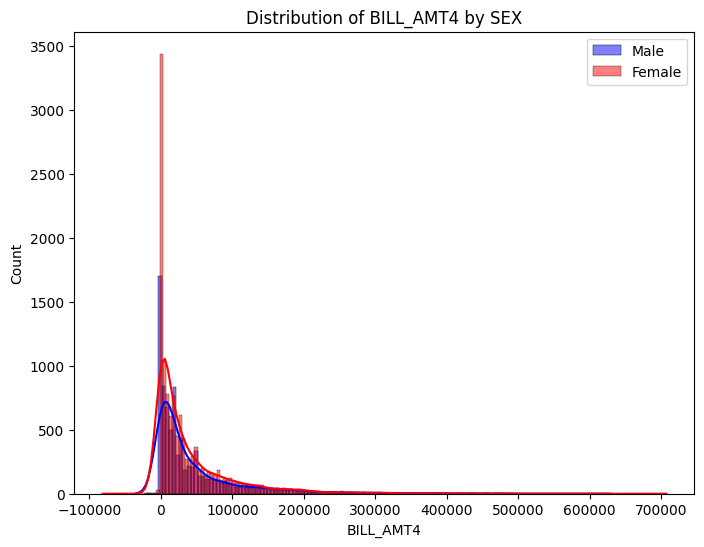

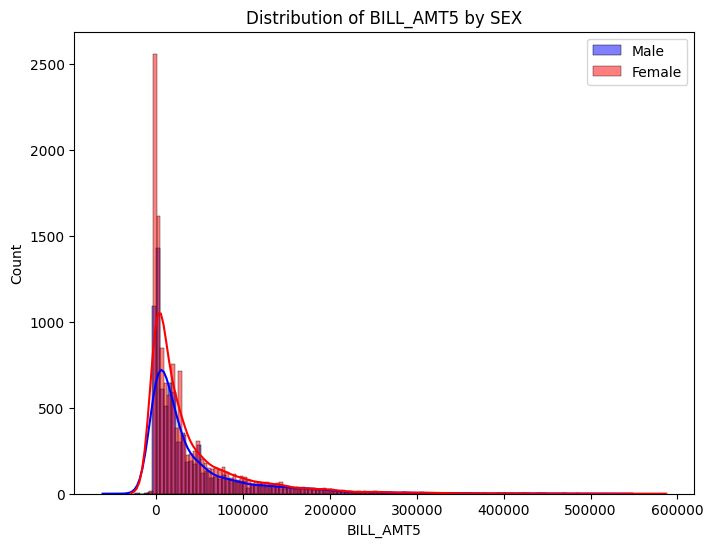

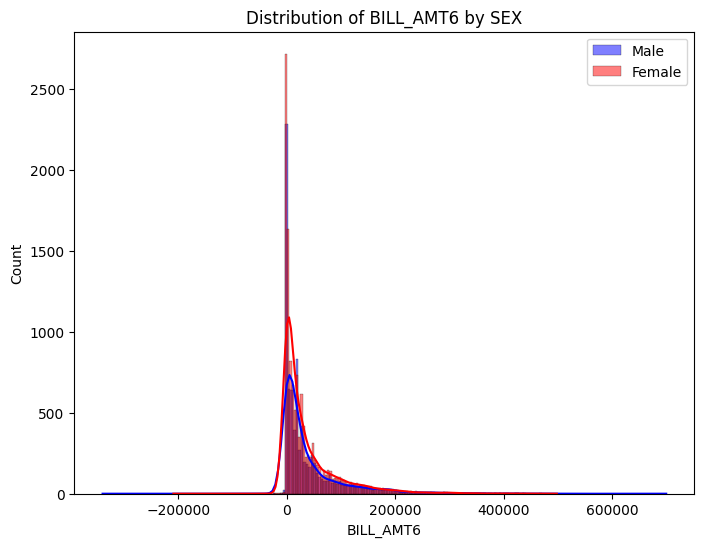

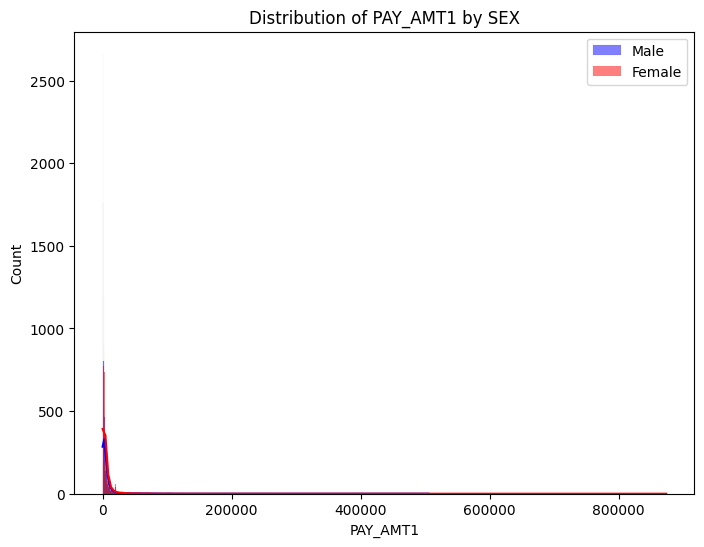

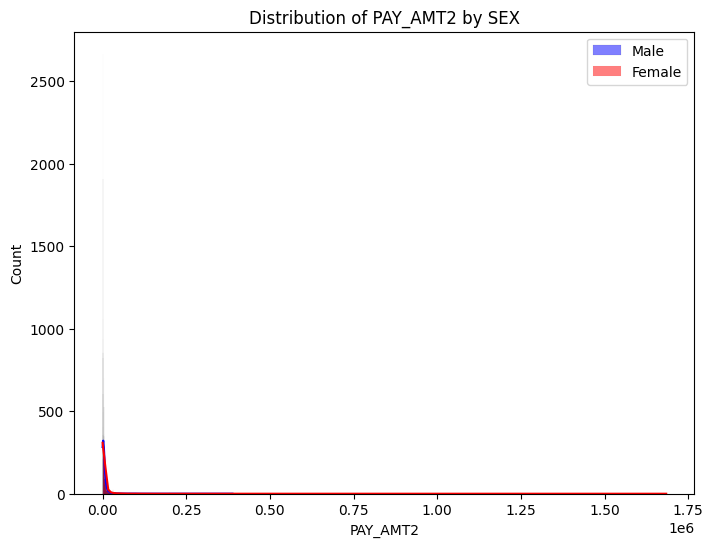

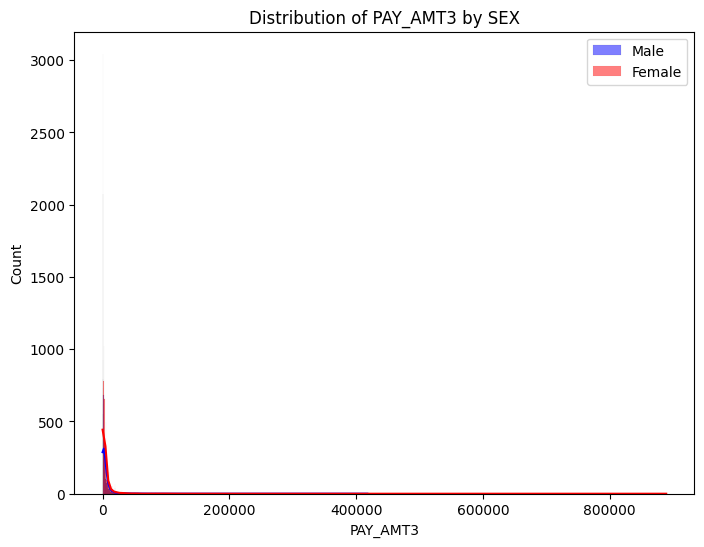

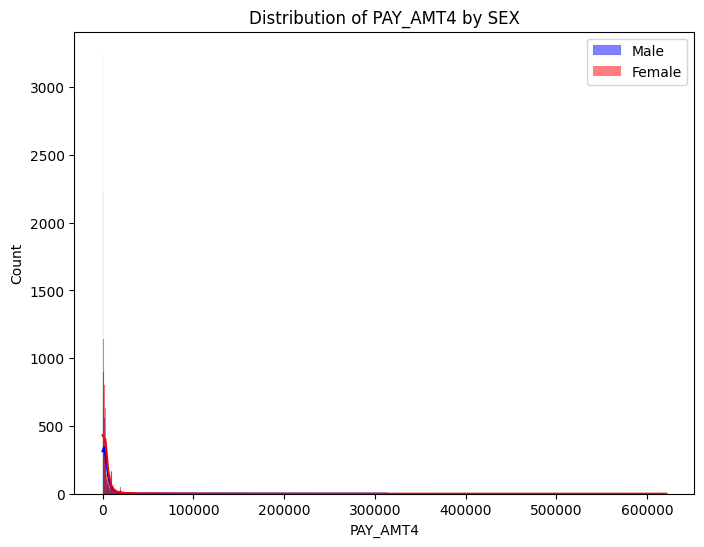

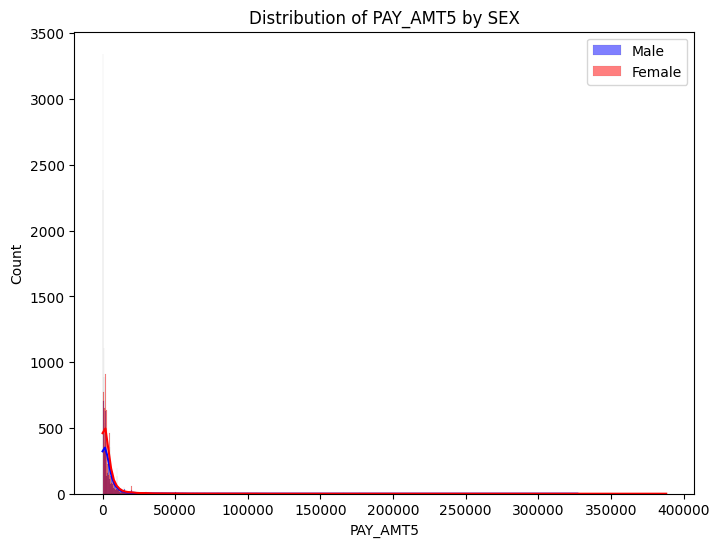

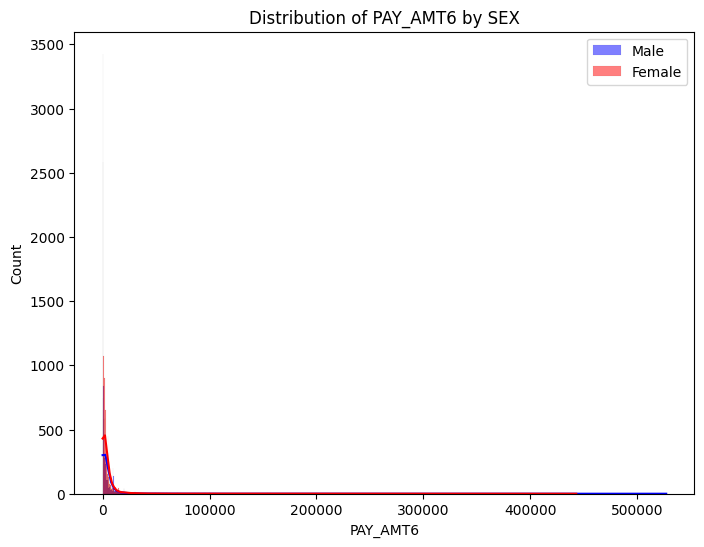

In [33]:
# Separate the dataset by class
male_data = df_train[df_train['SEX'] == 1]
female_data = df_train[df_train['SEX'] == 2]

# Get a list of features excluding SEX and the target variable
features = [col for col in df_train.columns if col not in ['SEX', 'default payment next month']]

# Plot distribution for each feature
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.histplot(male_data[feature], kde=True, color='blue', label='Male')
    sns.histplot(female_data[feature], kde=True, color='red', label='Female')
    plt.title(f'Distribution of {feature} by SEX')
    plt.legend()
    plt.show()

In [36]:
# load trained model
rf_model = pickle.load(open('../models/best_rf_unf.pkl', 'rb'))
#logreg_model = pickle.load(open('../models/best_logreg_unf.pkl', 'rb'))

In [37]:
# predict on validation dataset
X_val = df_val.drop(columns=['ID', 'default payment next month'])
# Random Forest model's prediction
y_hat_rf = rf_model.predict(X_val)

In [38]:
male_tpr, female_tpr, equal_opp_metric = equal_opp(df_val,
                                                   y_hat_rf,
                                                   df_val['default payment next month'],
                                                   1,
                                                   2,
                                                   'SEX')

In [39]:
# Compare true positive rates to assess fairness
if equal_opp_metric:
    print("Random Forest model: The algorithm has Equal Opportunity for both groups (male vs female).")
else:
    print("Random Forest model: The algorithm does not have Equal Opportunity for both groups (male vs female).")

# Output true positive rates
print("\nTrue Positive Rates:")
print("Male: {:.3f}".format(male_tpr))
print("Female: {:.3f}".format(female_tpr))
print('Equal Opportunity Metric: {:.3f}'.format(equal_opp_metric))

Random Forest model: The algorithm has Equal Opportunity for both groups (male vs female).

True Positive Rates:
Male: 0.664
Female: 0.657
Equal Opportunity Metric: 0.007


---
## Disparate impact

In [40]:
# calculating DI manually

def calc_prop(data, group_col, group, output_col, output_val):
    new = data[data[group_col] == group]
    return len(new[new[output_col] == output_val])/len(new)

In [41]:
parity_rate_male = calc_prop(df_train, "SEX", 1, "default payment next month", 0)
parity_rate_female = calc_prop(df_train, "SEX", 2, "default payment next month", 0)
print("parity_rate_male:", parity_rate_male)
print("parity_rate_female:", parity_rate_female)
print("parity rate ration female/male:", parity_rate_female/parity_rate_male)

parity_rate_male: 0.7529705323193916
parity_rate_female: 0.4723458359821996
parity rate ration female/male: 0.6273098557087252


In [42]:
# calculating DI using AIF360

privileged_groups = [{'SEX': 1}]
unprivileged_groups = [{'SEX': 2}]

binary_label_dataset_original = BinaryLabelDataset(df=df_train, 
                                        label_names=['default payment next month'], 
                                        protected_attribute_names=['SEX'],
                                        favorable_label=0, # non-default
                                        unfavorable_label=1, # default label
                                        )

di = BinaryLabelDatasetMetric(binary_label_dataset_original,
                              unprivileged_groups = unprivileged_groups,
                              privileged_groups = privileged_groups
                             ).disparate_impact()

print("Disparate Impact:", di)

Disparate Impact: 0.6273098557087252


### Average Odds Difference

In [43]:
# Convert the dataset into a binary label dataset
binary_label_dataset_original = BinaryLabelDataset(df=df_val, 
                                        label_names=['default payment next month'], 
                                        protected_attribute_names=['SEX'],
                                        favorable_label=0, # non-default
                                        unfavorable_label=1, # default label
                                        )


binary_label_dataset_predicted = binary_label_dataset_original.copy()

# Assume that the predicted labels of the model are stored in the array y_pred
binary_label_dataset_predicted.labels = y_hat_rf

# Calculate the classification metric
classified_metric_orig_training = ClassificationMetric(binary_label_dataset_original,
                                                       binary_label_dataset_predicted, 
                                                       unprivileged_groups=unprivileged_groups,
                                                       privileged_groups=privileged_groups)

# Calculate the Average Odds Difference
aod = classified_metric_orig_training.average_odds_difference()

print("Average Odds Difference:", aod)

Average Odds Difference: -0.11194134394931593


---
# Aplique duas metodologias de pré-processamento mais adequadas à aplicação escolhida.
---

### Reweighing

O método de Reweighing atribui pesos a cada exemplo no conjunto de dados de treinamento de tal forma que as distribuições estatísticas dos atributos protegidos sejam equivalentes para os resultados favoráveis e desfavoráveis.

In [44]:
from aif360.algorithms.preprocessing import Reweighing

# Convert the dataset into a binary label dataset
binary_label_dataset_train = BinaryLabelDataset(df=df_train, 
                                                label_names=['default payment next month'], 
                                                protected_attribute_names=['SEX'],
                                                favorable_label=0, 
                                                unfavorable_label=1)

# Initialize the reweighing algorithm
rw = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

# Fit and transform the dataset
binary_label_dataset_train_rw = rw.fit_transform(binary_label_dataset_train)

# Update the training dataframe with the new weights
df_train_rw = binary_label_dataset_train_rw.convert_to_dataframe()[0]

### Disparate Impact Remover

O Disparate Impact Remover modifica os valores dos atributos não protegidos de forma a remover o impacto desigual nos atributos protegidos.

In [45]:
from aif360.algorithms.preprocessing import DisparateImpactRemover

# Initialize the Disparate Impact Remover algorithm
dir = DisparateImpactRemover(repair_level=1.0)

# Fit and transform the dataset
binary_label_dataset_train_dir = dir.fit_transform(binary_label_dataset_train)

# Update the training dataframe with the modified features
df_train_dir = binary_label_dataset_train_dir.convert_to_dataframe()[0]

### Comparando

In [46]:
from sklearn.ensemble import RandomForestClassifier
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

# Prepare the training data
X_train_rw = df_train.drop(columns=['ID', 'default payment next month'])
y_train_rw = df_train['default payment next month']

X_train_dir = df_train_dir.drop(columns=['ID', 'default payment next month'])
y_train_dir = df_train_dir['default payment next month']

# Train the models
rf_model_rw = RandomForestClassifier()
rf_model_rw.fit(X_train_rw, y_train_rw)

rf_model_dir = RandomForestClassifier()
rf_model_dir.fit(X_train_dir, y_train_dir)

# Predict on the validation dataset
y_hat_rw = rf_model_rw.predict(X_val)
y_hat_dir = rf_model_dir.predict(X_val)

# Convert the predicted datasets into binary label datasets
binary_label_dataset_predicted_rw = binary_label_dataset_original.copy()
binary_label_dataset_predicted_rw.labels = y_hat_rw

binary_label_dataset_predicted_dir = binary_label_dataset_original.copy()
binary_label_dataset_predicted_dir.labels = y_hat_dir

# Calculate the classification metrics
classified_metric_rw = ClassificationMetric(binary_label_dataset_original,
                                            binary_label_dataset_predicted_rw, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

classified_metric_dir = ClassificationMetric(binary_label_dataset_original,
                                             binary_label_dataset_predicted_dir, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

# Calculate the Disparate Impact and Average Odds Difference
di_rw = BinaryLabelDatasetMetric(binary_label_dataset_predicted_rw,
                                 unprivileged_groups=unprivileged_groups,
                                 privileged_groups=privileged_groups
                                ).disparate_impact()

di_dir = BinaryLabelDatasetMetric(binary_label_dataset_predicted_dir,
                                  unprivileged_groups=unprivileged_groups,
                                  privileged_groups=privileged_groups
                                 ).disparate_impact()

aod_rw = classified_metric_rw.average_odds_difference()
aod_dir = classified_metric_dir.average_odds_difference()

print("Reweighing - Disparate Impact: ", di_rw)
print("Reweighing - Average Odds Difference: ", aod_rw)
print("Disparate Impact Remover - Disparate Impact: ", di_dir)
print("Disparate Impact Remover - Average Odds Difference: ", aod_dir)

Reweighing - Disparate Impact:  0.625314396072477
Reweighing - Average Odds Difference:  -0.22756269084327344
Disparate Impact Remover - Disparate Impact:  0.6696205876265805
Disparate Impact Remover - Average Odds Difference:  -0.18407137299539195


***Notamos que Disparate Impact Remover teve o maior impacto, torando DI mais próximo de 1 e AOD mais próximo de 0***

---
# Aplique duas metodologias de processamento mais adequadas à aplicação escolhida.
---

## Adversarial Debiasing

In [47]:
from aif360.algorithms.inprocessing import AdversarialDebiasing
import tensorflow.compat.v1 as tf

# Desativar o TensorFlow v2 para compatibilidade com aif360
tf.disable_v2_behavior()

# Criar uma sessão do TensorFlow
sess = tf.Session()

# Inicializar o Adversarial Debiasing
adv_debias = AdversarialDebiasing(privileged_groups=privileged_groups,
                                  unprivileged_groups=unprivileged_groups,
                                  scope_name="debiased_classifier",
                                  debias=True,
                                  sess=sess)

# Treinar o modelo Adversarial Debiasing
adv_debias.fit(binary_label_dataset_original)

# Prever no conjunto de validação
binary_label_dataset_predicted_adv_debias = adv_debias.predict(binary_label_dataset_original)

# Calcular métricas de imparcialidade
classified_metric_adv_debias = ClassificationMetric(binary_label_dataset_original,
                                                     binary_label_dataset_predicted_adv_debias, 
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

di_adv_debias = BinaryLabelDatasetMetric(binary_label_dataset_predicted_adv_debias,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups
                                        ).disparate_impact()

aod_adv_debias = classified_metric_adv_debias.average_odds_difference()

print("Adversarial Debiasing - Disparate Impact: ", di_adv_debias)
print("Adversarial Debiasing - Average Odds Difference: ", aod_adv_debias)

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
2023-12-10 10:47:22.518911: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


epoch 0; iter: 0; batch classifier loss: 10475.291016; batch adversarial loss: 1.989821
epoch 1; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 2; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 3; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 4; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 5; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 6; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 7; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 8; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 9; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 10; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 11; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 12; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 13; iter: 0; ba

In [48]:
from aif360.algorithms.inprocessing import PrejudiceRemover

# Inicializar o Prejudice Remover
pr = PrejudiceRemover(eta=25.0, sensitive_attr="SEX")

# Treinar o modelo Prejudice Remover
pr.fit(binary_label_dataset_original)

# Prever no conjunto de validação
binary_label_dataset_predicted_pr = pr.predict(binary_label_dataset_original)

# Calcular métricas de imparcialidade
classified_metric_pr = ClassificationMetric(binary_label_dataset_original,
                                            binary_label_dataset_predicted_pr, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

di_pr = BinaryLabelDatasetMetric(binary_label_dataset_predicted_pr,
                                 unprivileged_groups=unprivileged_groups,
                                 privileged_groups=privileged_groups
                                ).disparate_impact()

aod_pr = classified_metric_pr.average_odds_difference()

print("Prejudice Remover - Disparate Impact: ", di_pr)
print("Prejudice Remover - Average Odds Difference: ", aod_pr)

Traceback (most recent call last):
  File "/Users/mauriciopereiralopes/Library/Mobile Documents/com~apple~CloudDocs/git-repositories/mauricioplopes/ethical-machine-learning/ethical/lib/python3.11/site-packages/aif360/algorithms/inprocessing/kamfadm-2012ecmlpkdd/train_pr.py", line 319, in <module>
    main(opt)
  File "/Users/mauriciopereiralopes/Library/Mobile Documents/com~apple~CloudDocs/git-repositories/mauricioplopes/ethical-machine-learning/ethical/lib/python3.11/site-packages/aif360/algorithms/inprocessing/kamfadm-2012ecmlpkdd/train_pr.py", line 166, in main
    clr = train(X, y, ns, opt)
          ^^^^^^^^^^^^^^^^^^^^
  File "/Users/mauriciopereiralopes/Library/Mobile Documents/com~apple~CloudDocs/git-repositories/mauricioplopes/ethical-machine-learning/ethical/lib/python3.11/site-packages/aif360/algorithms/inprocessing/kamfadm-2012ecmlpkdd/train_pr.py", line 128, in train
    clr.fit(X, y, ns, itype=opt.itype)
  File "/Users/mauriciopereiralopes/Library/Mobile Documents/com~app

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

### Aprendizado justo

In [49]:
from sklearn.model_selection import RandomizedSearchCV

# Definir os conjuntos de treinamento e validação
X_train = df_train.drop(columns=['ID', 'default payment next month'])
y_train = df_train['default payment next month']

X_val = df_val.drop(columns=['ID', 'default payment next month'])
y_val = df_val['default payment next month']

# Definir a distribuição dos hiperparâmetros
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Criar um classificador Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Criar um objeto de busca aleatória
random_search = RandomizedSearchCV(rf_classifier, param_dist, cv=5, n_jobs=-1, n_iter=10)

# Ajustar a busca aleatória aos dados de treinamento
random_search.fit(X_train, y_train)

# Obter o melhor modelo Random Forest da busca aleatória
best_rf = random_search.best_estimator_

In [52]:
random_search.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 10}

In [50]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

# Define a restrição de paridade demográfica
dp_constraint = DemographicParity()

# Inicializa o Aprendizado Justo com o modelo base e a restrição
fair_model = ExponentiatedGradient(best_rf, dp_constraint)

# Treina o modelo
fair_model.fit(X_train, y_train, sensitive_features=df_train['SEX'])

# Preve no conjunto de validação
y_pred_fair = fair_model.predict(X_val)

# Calcula métricas de imparcialidade
binary_label_dataset_predicted_fair = binary_label_dataset_original.copy()
binary_label_dataset_predicted_fair.labels = y_pred_fair

classified_metric_fair = ClassificationMetric(binary_label_dataset_original,
                                              binary_label_dataset_predicted_fair, 
                                              unprivileged_groups=unprivileged_groups,
                                              privileged_groups=privileged_groups)

di_fair = BinaryLabelDatasetMetric(binary_label_dataset_predicted_fair,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups
                                  ).disparate_impact()

aod_fair = classified_metric_fair.average_odds_difference()

print("Fair Learning - Disparate Impact: ", di_fair)
print("Fair Learning - Average Odds Difference: ", aod_fair)

Fair Learning - Disparate Impact:  0.9697795567115696
Fair Learning - Average Odds Difference:  0.08134922722594967


In [51]:
# Save the best unbiased Random Forest model to a file
with open('../models/best_rf_fair.pkl', 'wb') as file:
    pickle.dump(best_rf, file)

---
# Aplique duas metodologias de pós-processamento mais adequadas à aplicação escolhida.
---

## Calibrated Model to Minimize Equalized Odds

In [92]:
from fairlearn.postprocessing import ThresholdOptimizer

postprocess_est = ThresholdOptimizer(
    estimator = rf_model,
    constraints = "equalized_odds",  # Optimize FPR and FNR simultaneously (wrong)
    # other constraints available: "selection_rate_parity", ’{false,true}_{positive,negative}_rate_parity’
    objective = "balanced_accuracy_score",
    prefit = True,
    predict_method = "predict_proba",
)

postprocess_est

ThresholdOptimizer(constraints='equalized_odds',
                   estimator=RandomForestClassifier(max_depth=10,
                                                    min_samples_split=10,
                                                    n_estimators=200,
                                                    random_state=42),
                   objective='balanced_accuracy_score',
                   predict_method='predict_proba', prefit=True)

In [94]:
X_train = df_train.drop(['ID', 'default payment next month'], axis = 1)
X_val = df_val.drop(['ID', 'default payment next month'], axis = 1)
y_train = df_train['default payment next month']
y_val = df_val['default payment next month']
sensitive_features_train = df_train.SEX
sensitive_features_val = df_val.SEX

In [95]:
postprocess_est.fit(X = X_train, y = y_train, sensitive_features = sensitive_features_train, random_seed = 42)

postprocess_pred = postprocess_est.predict(X_val, sensitive_features = sensitive_features_val)

In [96]:
# calculate Equal Opportunity Metric for the calibrated model

male_tpr, female_tpr, equal_opp_metric = equal_opp(df_val,
                                                   postprocess_pred,
                                                   df_val['default payment next month'],
                                                   1,
                                                   2,
                                                   'SEX')

# Compare true positive rates to assess fairness
if equal_opp_metric:
    print("Random Forest model: The algorithm has Equal Opportunity for both groups (male vs female).")
else:
    print("Random Forest model: The algorithm does not have Equal Opportunity for both groups (male vs female).")

# Output true positive rates
print("\nTrue Positive Rates:")
print("Male: {:.3f}".format(male_tpr))
print("Female: {:.3f}".format(female_tpr))
print('Equal Opportunity Metric: {:.3f}'.format(equal_opp_metric))

Random Forest model: The algorithm has Equal Opportunity for both groups (male vs female).

True Positive Rates:
Male: 0.368
Female: 0.627
Equal Opportunity Metric: -0.259


### Calibrated Equalized Odds Postprocessing (CEOP):

O CEOP ajusta as probabilidades de previsão do classificador para garantir a igualdade de oportunidades. Ele faz isso calibrando as probabilidades de previsão para cada grupo (privilegiado e não privilegiado) para que tenham a mesma distribuição.

In [98]:
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing

# Prever usando o melhor modelo Random Forest
y_pred_best_rf = best_rf.predict(X_val)
binary_label_dataset_original = BinaryLabelDataset(df=df_val, 
                                        label_names=['default payment next month'], 
                                        protected_attribute_names=['SEX'],
                                        favorable_label=0, # non-default
                                        unfavorable_label=1, # default label
                                        )
# Converter as previsões para um conjunto de dados de rótulo binário
binary_label_dataset_predicted_best_rf = binary_label_dataset_original.copy()
binary_label_dataset_predicted_best_rf.labels = y_pred_best_rf

# Inicializar o Calibrated Equalized Odds Postprocessing
ceop = CalibratedEqOddsPostprocessing(privileged_groups=privileged_groups,
                                      unprivileged_groups=unprivileged_groups,
                                      cost_constraint="fpr")

# Treinar o modelo CEOP
ceop.fit(binary_label_dataset_original, binary_label_dataset_predicted_best_rf)

# Prever no conjunto de validação
binary_label_dataset_predicted_ceop = ceop.predict(binary_label_dataset_predicted_best_rf)

# Calcular métricas de imparcialidade
classified_metric_ceop = ClassificationMetric(binary_label_dataset_original,
                                              binary_label_dataset_predicted_ceop, 
                                              unprivileged_groups=unprivileged_groups,
                                              privileged_groups=privileged_groups)

di_ceop = BinaryLabelDatasetMetric(binary_label_dataset_predicted_ceop,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups
                                  ).disparate_impact()

aod_ceop = classified_metric_ceop.average_odds_difference()

print("Calibrated Equalized Odds Postprocessing - Disparate Impact: ", di_ceop)
print("Calibrated Equalized Odds Postprocessing - Average Odds Difference: ", aod_ceop)

Calibrated Equalized Odds Postprocessing - Disparate Impact:  0.6123059709338724
Calibrated Equalized Odds Postprocessing - Average Odds Difference:  0.0


### Reject Option Classification (ROC):
O ROC é uma técnica que modifica as previsões do classificador, rejeitando algumas delas com base em um limiar de confiança. Isso pode melhorar a justiça, especialmente quando há uma sobreposição nas distribuições de pontuação para os grupos privilegiados e não privilegiados.

In [99]:
from aif360.algorithms.postprocessing import RejectOptionClassification

# Inicializar o Reject Option Classification
roc = RejectOptionClassification(unprivileged_groups=unprivileged_groups,
                                 privileged_groups=privileged_groups,
                                 low_class_thresh=0.01,
                                 high_class_thresh=0.99,
                                 num_class_thresh=100,
                                 num_ROC_margin=50,
                                 metric_name="Statistical parity difference",
                                 metric_ub=0.05,
                                 metric_lb=-0.05)

# Treinar o modelo ROC
roc.fit(binary_label_dataset_original, binary_label_dataset_predicted_best_rf)

# Prever no conjunto de validação
binary_label_dataset_predicted_roc = roc.predict(binary_label_dataset_predicted_best_rf)

# Calcular métricas de imparcialidade
classified_metric_roc = ClassificationMetric(binary_label_dataset_original,
                                             binary_label_dataset_predicted_roc, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

di_roc = BinaryLabelDatasetMetric(binary_label_dataset_predicted_roc,
                                  unprivileged_groups=unprivileged_groups,
                                  privileged_groups=privileged_groups
                                 ).disparate_impact()

aod_roc = classified_metric_roc.average_odds_difference()

print("Reject Option Classification - Disparate Impact: ", di_roc)
print("Reject Option Classification - Average Odds Difference: ", aod_roc)

Reject Option Classification - Disparate Impact:  0.6123059709338724
Reject Option Classification - Average Odds Difference:  0.0


c:\Users\mateu\anaconda3\envs\Sukuna\Lib\site-packages\aif360\algorithms\postprocessing\reject_option_classification.py:160: UserWarning: Unable to satisy fairness constraints
  warn("Unable to satisy fairness constraints")
